# Define MHWs using [Hobday definition](https://doi.org/10.1016/j.pocean.2015.12.014)
# SPEAR-LO
(>=5 consecutive days w/ a gap of >=3 days in between events for each grid cell)

|  | OISST | ERA5 | SPEAR-LO | SPEAR-HI (seperate nb) |
| :---------- | :---------- | :----------: | ----------: | ----------: |
| Temperature | SST | SST | SST | SST |
| Sampling<br>frequency | Daily | Daily | Daily | Daily |
| Lat/Lon<br>resolution | 0.25˚ x 0.25˚ | 0.25˚ x 0.25˚ | 1˚ x 1˚ | 0.25˚ x 0.25˚ |
|Time period | 1981-09 : 2025-09 | 1983-01 : 2021-06 | 1981-09 : 2010-12 | 1991-01 : 2100-01 |

In [1]:
import xarray as xr
import pandas as pd
import json
import numpy as np
import cmocean
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import LogNorm
import matplotlib.colors as mcolors
from matplotlib.colors import TwoSlopeNorm
import time
from tqdm import tqdm
import glob
import os
from collections import defaultdict
import xesmf as xe

## Plotting funcs

In [5]:
def cartopy_plot(da, cmap_choice, var_title=None, norm=None, ax=None):
    if ax is None:
        raise ValueError("This function now requires an axis when used for panels")

    ax.set_extent([-98, -60, 17.5, 31], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor='0.5'))

    # ---- model agnostic: infer coord names ----
    lat_name = next(c for c in ['lat','latitude','yT','yh'] if c in da.coords)
    lon_name = next(c for c in ['lon','longitude','xT','xh'] if c in da.coords)
    
    if lat_name is None or lon_name is None:
        raise ValueError(f"Could not infer lat/lon coordinates. " f"Found coords: {list(da.coords)}")
    # --------------------------------------------
    im = ax.pcolormesh(da[lon_name], da[lat_name], da, transform=ccrs.PlateCarree(), 
                       cmap=cmap_choice, norm=norm)

    ax.set_title(var_title, fontsize=10)
    gl = ax.gridlines(draw_labels=True, linewidth=0.3)
    gl.xlabels_top = False
    gl.ylabels_right = False

    return im # return the image for optional colorbar handling

In [6]:
def cartopy_plot_single(da, cmap_choice, cbar_label, var_title, vmin=None, vmax=None, norm=None, quiver=True):
    proj = ccrs.Mercator() #with Mercator you can put lat lon values.
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(projection=proj))
    ax.set_extent([-98, -60, 17.5, 31], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='face',
                                            facecolor='0.5'))
    # ---- infer coord names if not provided ----
    lat_candidates = ['lat', 'latitude', 'yT', 'yh']
    lon_candidates = ['lon', 'longitude', 'xT', 'xh']

    lat_name = next((c for c in lat_candidates if c in da.coords), None)
    lon_name = next((c for c in lon_candidates if c in da.coords), None)

    if lat_name is None or lon_name is None:
        raise ValueError(
            f"Could not infer lat/lon coordinates. "
            f"Found coords: {list(da.coords)}"
        )

    lats = da[lat_name]
    lons = da[lon_name]

    # ---- normalization logic ----
    if norm is None:
        # simple linear scaling
        norm = colors.Normalize(vmin=vmin, vmax=vmax)
    else:
        # override norm limits if vmin/vmax are supplied
        if vmin is not None:
            norm.vmin = vmin
        if vmax is not None:
            norm.vmax = vmax
    # -------------------------------------------------------------------------------
    im = ax.pcolormesh(lons, lats, da, transform=ccrs.PlateCarree(), 
                       norm=norm, cmap=cmap_choice)
    cb = fig.colorbar(im, ax=ax, shrink=0.25, pad=0.1)
    cb.set_label(fr"{cbar_label}", labelpad=8, fontsize=12)
    g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
    g1.xlabels_top = False
    g1.ylabels_right = False
    plt.title(f'{var_title}', fontsize=14, y=1.09)

## ERA5
Vars needed:
- detrended_intime
- threshold
- events_by_cell
- event_mask
- ex_int_oi

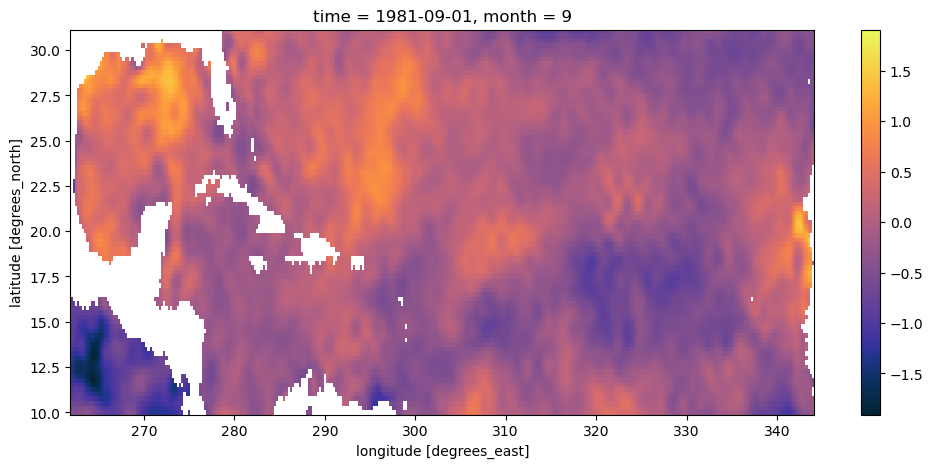

In [7]:
detrended_era[0].plot(figsize=(12,5), cmap=cmocean.cm.thermal)

In [8]:
%%time 
#--------------------------------------- EVENT COUNTS ------------------------------
# create empty array to get spatial and meta data
event_count_era = xr.zeros_like(ex_int_era.isel(time=0), dtype=int) #da of 0s
#for key (lat/lon), events (start/stop indices) in da dictionary:
#empty_da.loc[dict((lat, lon))] = len(all events in that grid cell)
for cell_str, events in events_by_cell_era.items(): #items are the lat/lon pairs
    lat, lon = map(float, cell_str.strip("()").split(","))
    event_count_era.loc[dict(latitude=lat, longitude=lon)] = len(events)

#--------------------------------------- TOTAL MHW DAYS ------------------------------
total_mhw_days_era = event_mask_era.sum(dim="time")

#--------------------------------------- DURATION ------------------------------
records_era = []
for cell_str, events in events_by_cell_era.items():
    lat, lon = map(float, cell_str.strip("()").split(","))
    for i, (start, end) in enumerate(events):
        records_era.append({"latitude": lat, "longitude": lon, "event": i, "duration": end - start + 1})

df = pd.DataFrame(records_era)
duration_da = (df.set_index(["latitude", "longitude", "event"]).to_xarray())["duration"]

mean_duration_era = duration_da.mean(dim="event")
median_duration_era = duration_da.median(dim="event")
max_duration_era = duration_da.max(dim="event")

#--------------------------------------- MHW Temperatures ------------------------------
mhw_events_era = detrended_era.where(event_mask_era)
mean_mhw_temp_era = mhw_events_era.mean(dim="time")

#--------------------------------------- Frequency ------------------------------
years_era = detrended_era.time.dt.year.values
nyears_era = np.unique(years_era).size #total time period
event_freq_era = event_count_era / nyears_era

#--------------------------------------- Intensity ------------------------------
mhw_intensity_era = (mhw_events_era - threshold_era).mean(dim="time")

CPU times: user 3min 49s, sys: 874 ms, total: 3min 50s
Wall time: 3min 51s


In [4]:
event_count_era = xr.open_dataarray('/work5/stb/MHW-gfdl/SPEAR/vars/ERA5/map_vars/event_count_era.nc', chunks={})
total_mhw_days_era = xr.open_dataarray('/work5/stb/MHW-gfdl/SPEAR/vars/ERA5/map_vars/total_mhw_days_era.nc', chunks={})
mean_duration_era = xr.open_dataarray('/work5/stb/MHW-gfdl/SPEAR/vars/ERA5/map_vars/mean_duration_era.nc', chunks={})
median_duration_era = xr.open_dataarray('/work5/stb/MHW-gfdl/SPEAR/vars/ERA5/map_vars/median_duration_era.nc', chunks={})
max_duration_era = xr.open_dataarray('/work5/stb/MHW-gfdl/SPEAR/vars/ERA5/map_vars/max_duration_era.nc', chunks={})
mean_mhw_temp_era = xr.open_dataarray('/work5/stb/MHW-gfdl/SPEAR/vars/ERA5/map_vars/mean_mhw_temp_era.nc', chunks={})
event_freq_era = xr.open_dataarray('/work5/stb/MHW-gfdl/SPEAR/vars/ERA5/map_vars/event_freq_era.nc', chunks={})
mhw_intensity_era= xr.open_dataarray('/work5/stb/MHW-gfdl/SPEAR/vars/ERA5/map_vars/mhw_intensity_era.nc', chunks={})

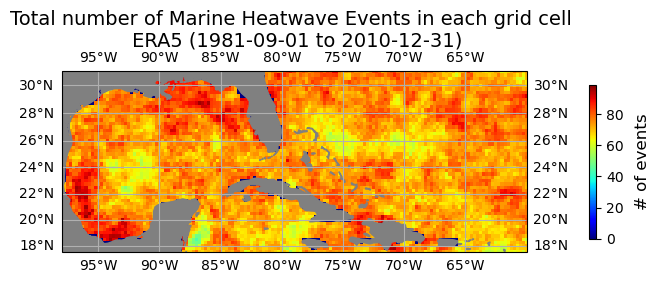

In [5]:
cartopy_plot_single(event_count_era, 'jet', '# of events', 
             'Total number of Marine Heatwave Events in each grid cell \n ERA5 (1981-09-01 to 2010-12-31)')

In [ ]:
cartopy_plot_single(ev_ct_oi_ng, 'jet', '# of events', 
             'Total number of Marine Heatwave Events in each grid cell \n OISST (1981-09-01 to 2010-12-31)')

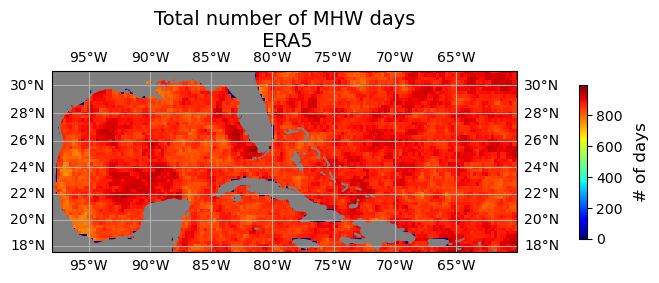

In [6]:
cartopy_plot_single(total_mhw_days_era, 'jet', '# of days', 
             'Total number of MHW days\n ERA5');#if time res is daily


In [ ]:
cartopy_plot_single(tot_mhw_days_oi_ng, 'jet', '# of days', 
             'Total number of MHW days\n OISST');#if time res is daily


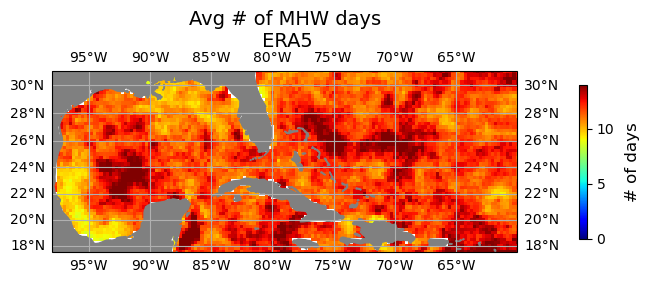

In [7]:
cartopy_plot_single(mean_duration_era, 'jet', '# of days', 
             'Avg # of MHW days\n ERA5',vmin=0, vmax=14,);#if time res is daily


In [ ]:
cartopy_plot_single(mean_dur_oi_ng, 'jet', '# of days', 
             'Avg # of MHW days\n OISST')#,vmin=0, vmax=14,);#if time res is daily


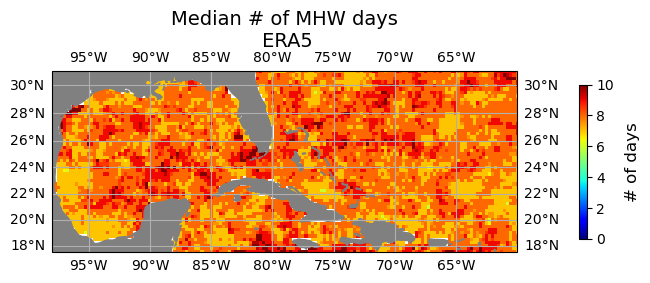

In [8]:
cartopy_plot_single(median_duration_era, 'jet', '# of days', 
             'Median # of MHW days\n ERA5', vmin=0, vmax=10);#if time res is daily


In [ ]:
cartopy_plot_single(med_dur_oi_ng, 'jet', '# of days', 
             'Median # of MHW days\n OISST');#if time res is daily


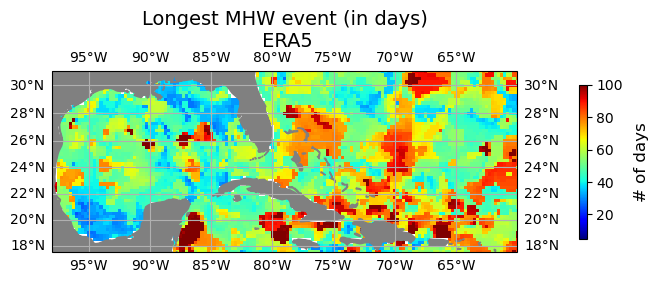

In [9]:
cartopy_plot_single(max_duration_era, 'jet', '# of days', 
             'Longest MHW event (in days)\n ERA5', vmin=5, vmax=100);

In [ ]:
cartopy_plot_single(max_dur_oi_ng, 'jet', '# of days', 
             'Longest MHW event (in days)\n OISST', vmin=5, vmax=100);

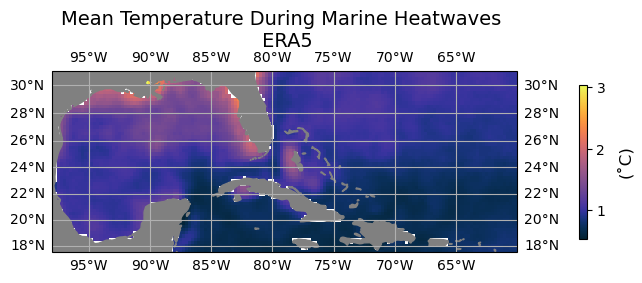

In [10]:
cartopy_plot_single(mean_mhw_temp_era, cmocean.cm.thermal, '(˚C)', 
             'Mean Temperature During Marine Heatwaves \n ERA5',);

In [ ]:
cartopy_plot_single(mean_mhw_tmp_oi_ng, cmocean.cm.thermal, '(˚C)', 
             'Mean Temperature During Marine Heatwaves \n OISST',);

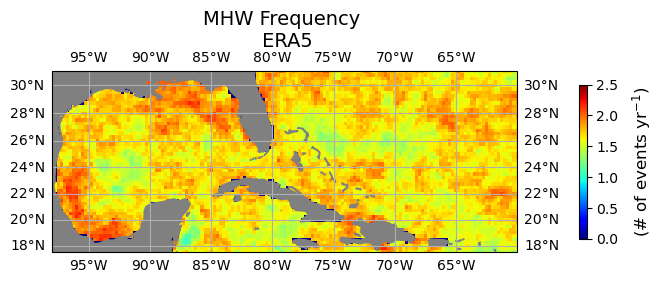

In [11]:
cartopy_plot_single(event_freq_era, 'jet', r'(# of events yr$^{-1}$)', 'MHW Frequency \n ERA5',
                   vmin=0, vmax=2.5);

In [ ]:
cartopy_plot_single(ev_freq_oi_ng, 'jet', r'(# of events yr$^{-1}$)', 'MHW Frequency \n OISST', 
                   vmin=0, vmax=2.5);

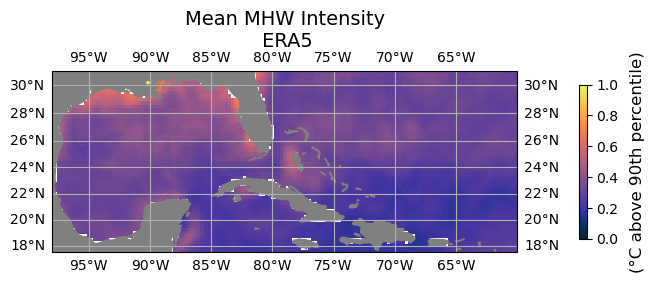

In [12]:
cartopy_plot_single(mhw_intensity_era, cmocean.cm.thermal, '(°C above 90th percentile)', 
             'Mean MHW Intensity\n ERA5', vmin=0, vmax=1); 

In [ ]:
cartopy_plot_single(mhw_int_oi_ng, cmocean.cm.thermal, '(°C above 90th percentile)', 
             'Mean MHW Intensity\n OISST', vmin=0, vmax=1); 

## OISST
Vars needed:
- detrended_intime
- threshold
- events_by_cell
- event_mask
- ex_int_oi

In [2]:
detrended_oi_ds = xr.open_dataarray('/work5/stb/MHW-gfdl/SPEAR/vars/OISST/detrended_intime_oisst_anom.nc', chunks={})
detrended_oi = detrended_oi_ds.sel(time=slice(None, '2010'))
ex_int_oi = xr.open_dataarray('/work5/stb/MHW-gfdl/SPEAR/vars/OISST/ex_int_oi.nc', chunks={})
threshold_oi = xr.open_dataarray('/work5/stb/MHW-gfdl/SPEAR/vars/OISST/threshold_oi.nc', chunks={})
event_mask_oi = xr.open_dataarray('/work5/stb/MHW-gfdl/SPEAR/vars/OISST/event_mask_oi.nc', chunks={})

In [3]:
import json

with open('/work5/stb/MHW-gfdl/SPEAR/vars/OISST/events_by_cell_oi.json', 'r') as json_file:
    events_by_cell_oi = json.load(json_file)

In [4]:
%%time 
#--------------------------------------- EVENT COUNTS ------------------------------
# create empty array to get spatial and meta data
event_count_oi = xr.zeros_like(ex_int_oi.isel(time=0), dtype=int) #da of 0s
#for key (lat/lon), events (start/stop indices) in da dictionary:
#empty_da.loc[dict((lat, lon))] = len(all events in that grid cell)
for cell_str, events in events_by_cell_oi.items(): #items are the lat/lon pairs
    lat, lon = map(float, cell_str.strip("()").split(","))
    event_count_oi.loc[dict(lat=lat, lon=lon)] = len(events)

#--------------------------------------- TOTAL MHW DAYS ------------------------------
total_mhw_days_oi = event_mask_oi.sum(dim="time")

#--------------------------------------- DURATION ------------------------------
records_oi = []
for cell_str, events in events_by_cell_oi.items():
    lat, lon = map(float, cell_str.strip("()").split(","))
    for i, (start, end) in enumerate(events):
        records_oi.append({"lat": lat, "lon": lon, "event": i, "duration": end - start + 1})

df = pd.DataFrame(records_oi)
duration_da = (df.set_index(["lat", "lon", "event"]).to_xarray())["duration"]

mean_duration_oi = duration_da.mean(dim="event")
median_duration_oi = duration_da.median(dim="event")
max_duration_oi = duration_da.max(dim="event")

#--------------------------------------- MHW Temperatures ------------------------------
mhw_events_oi = detrended_oi.where(event_mask_oi)
mean_mhw_temp_oi = mhw_events_oi.mean(dim="time")

#--------------------------------------- Frequency ------------------------------
years_oi = detrended_oi.time.dt.year.values
nyears_oi = np.unique(years_oi).size #total time period
event_freq_oi = event_count_oi / nyears_oi

#--------------------------------------- Intensity ------------------------------
mhw_intensity_oi = (mhw_events_oi - threshold_oi).mean(dim="time")

CPU times: user 6min 46s, sys: 1.58 s, total: 6min 48s
Wall time: 6min 52s


In [8]:
#merged to_netcdf cells
event_count_oi.drop_vars(('month', 'quantile', 'dayofyear')).to_netcdf('/work5/stb/MHW-gfdl/SPEAR/vars/OISST/map_vars/event_count_oi.nc',
                                                                       mode='w')

In [10]:
total_mhw_days_oi.drop_vars('quantile').to_netcdf('/work5/stb/MHW-gfdl/SPEAR/vars/OISST/map_vars/total_mhw_days_oi.nc',
                                                   mode='w')

In [11]:
mean_duration_oi.to_netcdf('/work5/stb/MHW-gfdl/SPEAR/vars/OISST/map_vars/mean_duration_oi.nc', mode='w')

In [12]:
median_duration_oi.to_netcdf('/work5/stb/MHW-gfdl/SPEAR/vars/OISST/map_vars/median_duration_oi.nc', mode='w')

In [13]:
max_duration_oi.to_netcdf('/work5/stb/MHW-gfdl/SPEAR/vars/OISST/map_vars/max_duration_oi.nc', mode='w')

In [15]:
mean_mhw_temp_oi.drop_vars('quantile').to_netcdf('/work5/stb/MHW-gfdl/SPEAR/vars/OISST/map_vars/mean_mhw_temp_oi.nc',
                                                    mode='w')

In [17]:
event_freq_oi.drop_vars(('month', 'quantile', 'dayofyear')).to_netcdf('/work5/stb/MHW-gfdl/SPEAR/vars/OISST/map_vars/event_freq_oi.nc',
                                                                       mode='w')

In [19]:
mhw_intensity_oi.drop_vars('quantile').to_netcdf('/work5/stb/MHW-gfdl/SPEAR/vars/OISST/map_vars/mhw_intensity_oi.nc',
                                                  mode='w')

In [20]:
event_count_oi = xr.open_dataarray('/work5/stb/MHW-gfdl/SPEAR/vars/OISST/map_vars/event_count_oi.nc', chunks={})
total_mhw_days_oi = xr.open_dataarray('/work5/stb/MHW-gfdl/SPEAR/vars/OISST/map_vars/total_mhw_days_oi.nc', chunks={})
mean_duration_oi = xr.open_dataarray('/work5/stb/MHW-gfdl/SPEAR/vars/OISST/map_vars/mean_duration_oi.nc', chunks={})
median_duration_oi = xr.open_dataarray('/work5/stb/MHW-gfdl/SPEAR/vars/OISST/map_vars/median_duration_oi.nc', chunks={})
max_duration_oi = xr.open_dataarray('/work5/stb/MHW-gfdl/SPEAR/vars/OISST/map_vars/max_duration_oi.nc', chunks={})
mean_mhw_temp_oi = xr.open_dataarray('/work5/stb/MHW-gfdl/SPEAR/vars/OISST/map_vars/mean_mhw_temp_oi.nc', chunks={})
event_freq_oi= xr.open_dataarray('/work5/stb/MHW-gfdl/SPEAR/vars/OISST/map_vars/event_freq_oi.nc', chunks={})
mhw_intensity_oi= xr.open_dataarray('/work5/stb/MHW-gfdl/SPEAR/vars/OISST/map_vars/mhw_intensity_oi.nc', chunks={})

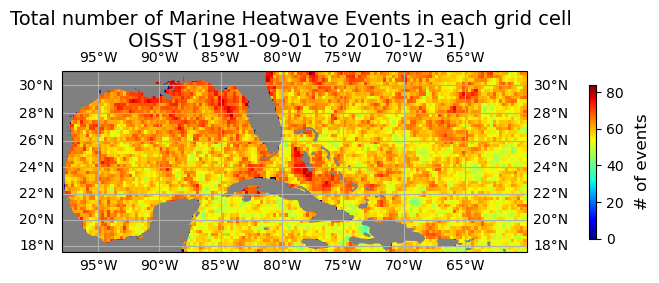

In [21]:
cartopy_plot_single(event_count_oi, 'jet', '# of events', 
             'Total number of Marine Heatwave Events in each grid cell \n OISST (1981-09-01 to 2010-12-31)')

In [ ]:
cartopy_plot_single(ev_ct_oi_ng, 'jet', '# of events', 
             'Total number of Marine Heatwave Events in each grid cell \n OISST (1981-09-01 to 2010-12-31)')

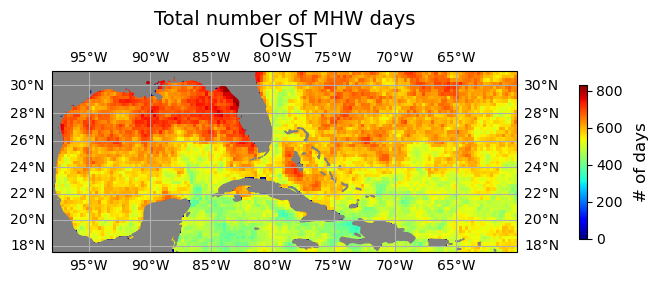

In [22]:
cartopy_plot_single(total_mhw_days_oi, 'jet', '# of days', 
             'Total number of MHW days\n OISST');#if time res is daily


In [ ]:
cartopy_plot_single(tot_mhw_days_oi_ng, 'jet', '# of days', 
             'Total number of MHW days\n OISST');#if time res is daily


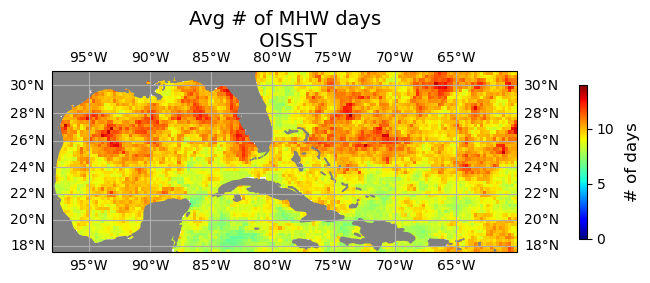

In [23]:
cartopy_plot_single(mean_duration_oi, 'jet', '# of days', 
             'Avg # of MHW days\n OISST',vmin=0, vmax=14,);#if time res is daily


In [ ]:
cartopy_plot_single(mean_dur_oi_ng, 'jet', '# of days', 
             'Avg # of MHW days\n OISST')#,vmin=0, vmax=14,);#if time res is daily


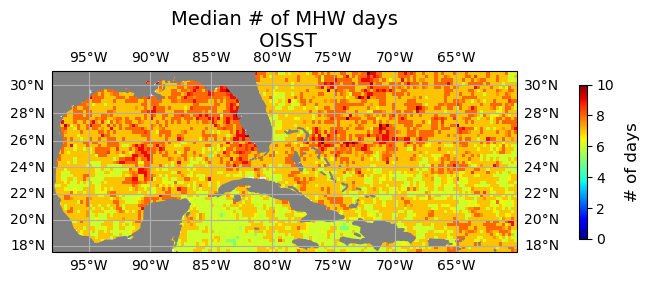

In [24]:
cartopy_plot_single(median_duration_oi, 'jet', '# of days', 
             'Median # of MHW days\n OISST', vmin=0, vmax=10);#if time res is daily


In [ ]:
cartopy_plot_single(med_dur_oi_ng, 'jet', '# of days', 
             'Median # of MHW days\n OISST');#if time res is daily


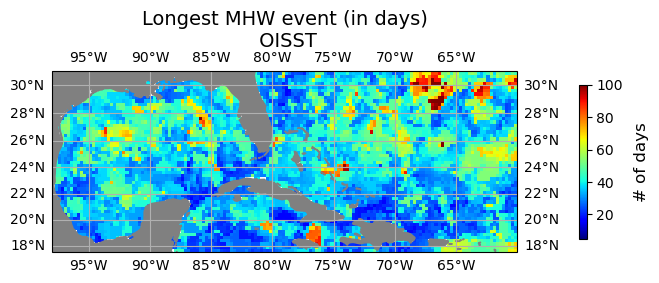

In [25]:
cartopy_plot_single(max_duration_oi, 'jet', '# of days', 
             'Longest MHW event (in days)\n OISST', vmin=5, vmax=100);

In [ ]:
cartopy_plot_single(max_dur_oi_ng, 'jet', '# of days', 
             'Longest MHW event (in days)\n OISST', vmin=5, vmax=100);

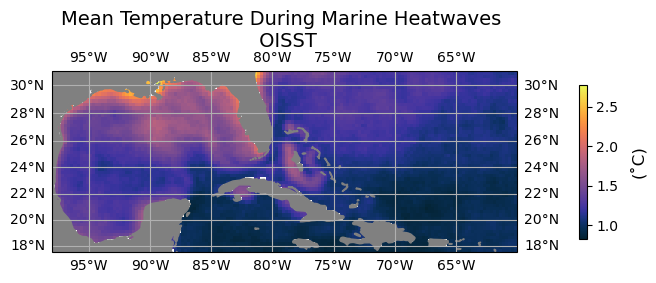

In [26]:
cartopy_plot_single(mean_mhw_temp_oi, cmocean.cm.thermal, '(˚C)', 
             'Mean Temperature During Marine Heatwaves \n OISST',);

In [ ]:
cartopy_plot_single(mean_mhw_tmp_oi_ng, cmocean.cm.thermal, '(˚C)', 
             'Mean Temperature During Marine Heatwaves \n OISST',);

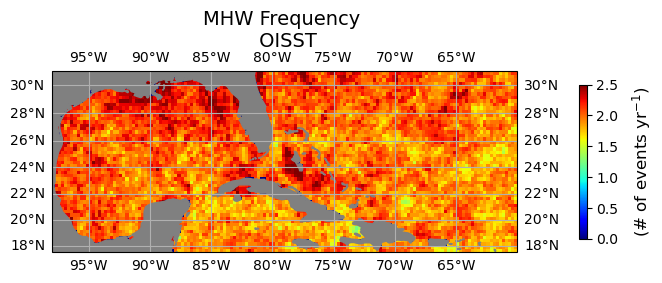

In [27]:
cartopy_plot_single(event_freq_oi, 'jet', r'(# of events yr$^{-1}$)', 'MHW Frequency \n OISST',
                   vmin=0, vmax=2.5);

In [ ]:
cartopy_plot_single(ev_freq_oi_ng, 'jet', r'(# of events yr$^{-1}$)', 'MHW Frequency \n OISST', 
                   vmin=0, vmax=2.5);

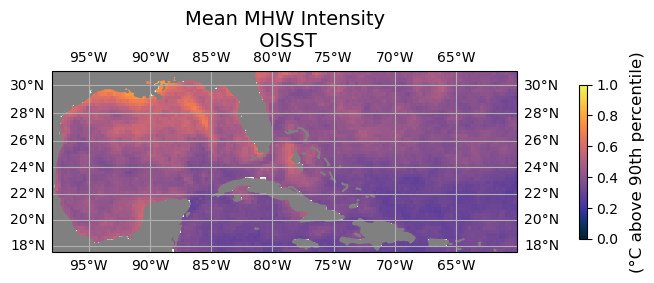

In [28]:
cartopy_plot_single(mhw_intensity_oi, cmocean.cm.thermal, '(°C above 90th percentile)', 
             'Mean MHW Intensity\n OISST', vmin=0, vmax=1); 

In [ ]:
cartopy_plot_single(mhw_int_oi_ng, cmocean.cm.thermal, '(°C above 90th percentile)', 
             'Mean MHW Intensity\n OISST', vmin=0, vmax=1); 

## SPEAR-LO

In [ ]:
#detrended SSTs
files = sorted(glob.glob('/work5/stb/MHW-gfdl/SPEAR/vars/SPEAR-LO/detrended/detrended_intime_spear_lo*.nc'))
detrended_splo = []
for f in files:
    ds = xr.open_dataset(f, chunks={})
    da = next(iter(ds.data_vars.values()))
    #take the # in filename and add it to darr name
    ens = os.path.basename(f).split('_lo')[-1].split('.nc')[0] 
    da = da.rename(f'SST_ens{ens}')
    detrended_splo.append(da)

In [ ]:
#darr of 1s/0s of SSTs>90th percentile
files = sorted(glob.glob('/work5/stb/MHW-gfdl/SPEAR/vars/SPEAR-LO/exceedance/ex_int_splo*.nc'))
ex_int_splo = []
for f in files:
    ds = xr.open_dataset(f, chunks={})
    da = next(iter(ds.data_vars.values()))
    #take the # in filename and add it to darr name
    ens = os.path.basename(f).split('_lo')[-1].split('.nc')[0] 
    da = da.rename(f'{ens}')
    ex_int_splo.append(da)

In [ ]:
#darr of 90th percentile SSTs
files = sorted(glob.glob('/work5/stb/MHW-gfdl/SPEAR/vars/SPEAR-LO/exceedance/threshold_splo*.nc'))
threshold_splo = []
for f in files:
    ds = xr.open_dataset(f, chunks={})
    da = next(iter(ds.data_vars.values()))
    #take the # in filename and add it to darr name
    ens = os.path.basename(f).split('_lo')[-1].split('.nc')[0] 
    da = da.rename(f'{ens}')
    threshold_splo.append(da)

In [ ]:
#darr following criteria (>=90th, >=5 consec days, >=3 day gaps)
files = sorted(glob.glob('/work5/stb/MHW-gfdl/SPEAR/vars/SPEAR-LO/events/event_mask_splo*.nc'))
event_mask_splo = []
for f in files:
    ds = xr.open_dataset(f, chunks={})
    da = next(iter(ds.data_vars.values()))
    #take the # in filename and add it to darr name
    ens = os.path.basename(f).split('_lo')[-1].split('.nc')[0] 
    da = da.rename(f'{ens}')
    event_mask_splo.append(da)

In [ ]:
event_mask_splo

In [ ]:
with open('/work5/stb/MHW-gfdl/SPEAR/vars/SPEAR-LO/events/events_by_cell_splo.json', 'r') as json_file:
    events_by_cell_splo = json.load(json_file)

In [ ]:
%%time
#--------------------------------------- EVENT COUNTS <2min ------------------------------
event_counts_splo = []

for da, events_by_cell in zip(ex_int_splo, events_by_cell_splo):
    # create empty event-count array for this DA
    event_count = xr.zeros_like(da.isel(time=0), dtype=int).rename(f'event_count_ens{da.name[-2:]}')
    # fill it using the corresponding dictionary
    for cell_str, events in events_by_cell.items():
        lat, lon = map(float, cell_str.strip("()").split(","))
        event_count.loc[dict(yT=lat, xT=lon)] = len(events)

    event_counts_splo.append(event_count)

In [ ]:
event_counts_splo

In [ ]:
%%time
#--------------------------------------- TOTAL MHW DAYS <1sec ------------------------------
total_mhw_days = []
for da in event_mask_splo:
    total_mhw_days.append(da.sum(dim="time"))

In [ ]:
total_mhw_days

In [ ]:
#sanity check 
len(events_by_cell_splo)

In [ ]:
%%time
#--------------------------------------- DURATION <10 sec (xr method) ------------------------------
# Get all unique cells from the first ensemble member
cells = list(events_by_cell_splo[0].keys())
lats, lons = zip(*(map(float, c.strip("()").split(",")) for c in cells))

# Convert to sorted unique lat/lon for grid
unique_lats = np.unique(lats)
unique_lons = np.unique(lons)

# Create mapping from cell string to grid indices
lat_idx = {lat: i for i, lat in enumerate(unique_lats)}
lon_idx = {lon: i for i, lon in enumerate(unique_lons)}

# Dimensions
n_ens = len(events_by_cell_splo)
n_lat = len(unique_lats)
n_lon = len(unique_lons)
max_events = max(len(events) for member in events_by_cell_splo for events in member.values())

# Preallocate array: ensemble × lat × lon × event
data = np.full((n_ens, n_lat, n_lon, max_events), np.nan)

# Fill the array
for ei, member in enumerate(events_by_cell_splo):
    for cell_str, events in member.items():
        lat, lon = map(float, cell_str.strip("()").split(","))
        li, lj = lat_idx[lat], lon_idx[lon]
        durations = [end - start + 1 for start, end in events]
        data[ei, li, lj, :len(durations)] = durations

# Create xarray DataArray
duration_da = xr.DataArray(data, dims=["ensemble", "yT", "xT", "event"],
                           coords={"ensemble": np.arange(n_ens), "yT": unique_lats, "xT": unique_lons})

# Compute per-cell statistics over events
mean_duration = duration_da.mean(dim="event", skipna=True)
median_duration = duration_da.median(dim="event", skipna=True)
max_duration = duration_da.max(dim="event", skipna=True)

# Compute statistics across ensembles
mean_duration_across_ensemble = mean_duration.mean(dim="ensemble")
median_duration_across_ensemble = median_duration.median(dim="ensemble")
max_duration_across_ensemble = max_duration.max(dim="ensemble")

In [ ]:
n_ens

In [ ]:
duration_da

In [ ]:
%%time 
#--------------------------------------- MHW Temperatures <2sec ------------------------------mhw_events = []
mhw_events = [] #detrended SSTs during mhw events
mean_mhw_temp = [] #time-avg detrended SSTs of all MHW events at each grid cell
for da, mask in zip(detrended_splo, event_mask_splo):
    mhw = da.where(mask)
    mean_temp = mhw.mean(dim="time")
    
    mhw_events.append(mhw)
    mean_mhw_temp.append(mean_temp)

In [ ]:
mhw_events[0][0].plot()

In [ ]:
mean_mhw_temp

In [ ]:
%%time
#--------------------------------------- Frequency <1sec ------------------------------
years = detrended_splo[0].time.dt.year.values
nyears = np.unique(years).size #total time period
# compute event frequency for all ensemble members
event_freq_splo = [da_events / nyears for da_events in event_counts_splo]

In [ ]:
%%time
#--------------------------------------- Intensity <1sec------------------------------
mhw_intensity_splo = []
for mhws, thresh in zip(mhw_events, threshold_splo):
    intensity = (mhws - thresh).mean(dim="time").rename(f'intensity_ens{mhws.name[-2:]}')
    mhw_intensity_splo.append(intensity)

### Plots

In [ ]:
%%time
fig, ax = plt.subplots(6, 5, figsize=(20, 15), subplot_kw=dict(projection=ccrs.Mercator()))
ax_flat = ax.flatten()

# ---- shared normalization (CRITICAL for colorbar) ----
# temporarily stack ensemble members into one DataArray to get min/max
stacked = xr.concat(event_counts_splo, dim="ensemble") #xr creates an 'ens' dim to stack da's along
vmin = stacked.min().compute().item()
vmax = stacked.max().compute().item()
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

for i in range(30):
    ens_name = f"ens{i+1:02d}"
    title = f"{ens_name}"
    im = cartopy_plot(event_counts_splo[i], cmap_choice='jet', var_title=title, norm=norm, ax=ax_flat[i])

# ---- single shared colorbar ----
cbar_ax = fig.add_axes([0.965, 0.33, 0.012, 0.38]) # move: [to right, it up, make thinner, shorter]
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('# of days', fontsize=14)
cbar.ax.tick_params(labelsize=12)

fig.suptitle("Total Number of Marine Heatwave Events\nSPEAR-LO (All Ensemble Members) \n (1981-09-01 to 2010-12-31)",
    fontsize=18, y=1.01)

# ---- spacing (Cartopy-safe) ----
fig.subplots_adjust(left=0.05, right=0.9, top=0.95, bottom=0.03, wspace=0.45, hspace=0.001)
plt.show()

In [ ]:
%%time
fig, ax = plt.subplots(6, 5, figsize=(20, 15), subplot_kw=dict(projection=ccrs.Mercator()))
ax_flat = ax.flatten()

# ---- shared normalization (CRITICAL for colorbar) ----
# temporarily stack ensemble members into one DataArray to get min/max
stacked = xr.concat(total_mhw_days, dim="ensemble")
vmin = stacked.min().compute().item()
vmax = stacked.max().compute().item()
norm = mcolors.Normalize(vmin=500, vmax=vmax)

for i in range(30):
    ens_name = f"ens{i+1:02d}"
    title = f"{ens_name}"
    im = cartopy_plot(total_mhw_days[i], cmap_choice='jet', var_title=title, norm=norm, ax=ax_flat[i])

# ---- single shared colorbar ----
cbar_ax = fig.add_axes([0.965, 0.33, 0.012, 0.38]) # move: [to right, it up, make thinner, shorter]
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('# of days', fontsize=14)
cbar.ax.tick_params(labelsize=12)

fig.suptitle("Total number of MHW days\n SPEAR-LO (All Ensemble Members) \n (1981-09-01 to 2010-12-31)",
    fontsize=18, y=1.01)

# ---- spacing (Cartopy-safe) ----
fig.subplots_adjust(left=0.05, right=0.9, top=0.95, bottom=0.03, wspace=0.45, hspace=0.001)
plt.show()

In [ ]:
%%time
fig, ax = plt.subplots(6, 5, figsize=(20, 15), subplot_kw=dict(projection=ccrs.Mercator()))
ax_flat = ax.flatten()

# ---- shared normalization (CRITICAL for colorbar) ----
# temporarily stack ensemble members into one DataArray to get min/max
vmin = mean_duration.min().item()
vmax = mean_duration.max().item()
norm = mcolors.Normalize(vmin=vmin, vmax=22)

for i in range(30):
    ens_name = f"ens{i+1:02d}"
    title = f"{ens_name}"
    im = cartopy_plot(mean_duration.isel(ensemble=i), cmap_choice='jet', var_title=title, 
                      norm=norm, ax=ax_flat[i])

# ---- single shared colorbar ----
cbar_ax = fig.add_axes([0.965, 0.33, 0.012, 0.38]) # move: [to right, it up, make thinner, shorter]
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('# of days', fontsize=14)
cbar.ax.tick_params(labelsize=12)

fig.suptitle("Avg # of MHW days\nSPEAR-LO (All Ensemble Members) \n (1981-09-01 to 2010-12-31)",
    fontsize=18, y=1.01)

# ---- spacing (Cartopy-safe) ----
fig.subplots_adjust(left=0.05, right=0.9, top=0.95, bottom=0.03, wspace=0.45, hspace=0.001)
plt.show()

In [ ]:
%%time
fig, ax = plt.subplots(6, 5, figsize=(20, 15), subplot_kw=dict(projection=ccrs.Mercator()))
ax_flat = ax.flatten()

# ---- shared normalization (CRITICAL for colorbar) ----
# temporarily stack ensemble members into one DataArray to get min/max
vmin = median_duration.min().item()
vmax = median_duration.max().item()
norm = mcolors.Normalize(vmin=6, vmax=18) #extreme outliers skew cmap so manually enter values

for i in range(30):
    ens_name = f"ens{i+1:02d}"
    title = f"{ens_name}"
    im = cartopy_plot(median_duration.isel(ensemble=i), cmap_choice='jet', var_title=title, 
                      norm=norm, ax=ax_flat[i])

# ---- single shared colorbar ----
cbar_ax = fig.add_axes([0.965, 0.33, 0.012, 0.38]) # move: [to right, it up, make thinner, shorter]
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('# of days', fontsize=14)
cbar.ax.tick_params(labelsize=12)

fig.suptitle("'Median # of MHW days\n SPEAR-LO (All Ensemble Members) \n (1981-09-01 to 2010-12-31)",
    fontsize=18, y=1.01)

# ---- spacing (Cartopy-safe) ----
fig.subplots_adjust(left=0.05, right=0.9, top=0.95, bottom=0.03, wspace=0.45, hspace=0.001)
plt.show()

In [ ]:
%%time
fig, ax = plt.subplots(6, 5, figsize=(20, 15), subplot_kw=dict(projection=ccrs.Mercator()))
ax_flat = ax.flatten()

# ---- shared normalization (CRITICAL for colorbar) ----
# temporarily stack ensemble members into one DataArray to get min/max
vmin = max_duration.min().item()
vmax = max_duration.max().item()
norm = mcolors.Normalize(vmin=30, vmax=180) #extreme outliers skew cmap so manually enter values

for i in range(30):
    ens_name = f"ens{i+1:02d}"
    title = f"{ens_name}"
    im = cartopy_plot(max_duration.isel(ensemble=i), cmap_choice='jet', var_title=title, 
                      norm=norm, ax=ax_flat[i])

# ---- single shared colorbar ----
#move[to right, it up, make thinner, shorter][left, bottom, width, height]
cbar_ax = fig.add_axes([0.965, 0.33, 0.012, 0.38]) 
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('# of days', fontsize=14)
cbar.ax.tick_params(labelsize=12)

fig.suptitle("Longest MHW event (in days) \n SPEAR-LO (All Ensemble Members) \n (1981-09-01 to 2010-12-31)",
    fontsize=18, y=1.01)

# ---- spacing (Cartopy-safe) ----
fig.subplots_adjust(left=0.05, right=0.9, top=0.95, bottom=0.03, wspace=0.45, hspace=0.001)
plt.show()

In [ ]:
%%time
fig, ax = plt.subplots(6, 5, figsize=(20, 15), subplot_kw=dict(projection=ccrs.Mercator()))
ax_flat = ax.flatten()

# ---- shared normalization (CRITICAL for colorbar) ----
# temporarily stack ensemble members into one DataArray to get min/max
stacked = xr.concat(mean_mhw_temp, dim="ensemble") #xr creates an 'ens' dim to stack da's along
vmin = stacked.min().compute().item()
vmax = stacked.max().compute().item()
norm = mcolors.Normalize(vmin=0.5, vmax=2.25)

for i in range(30):
    ens_name = f"ens{i+1:02d}"
    title = f"{ens_name}"
    im = cartopy_plot(mean_mhw_temp[i], cmap_choice=cmocean.cm.thermal, var_title=title, norm=norm, ax=ax_flat[i])

# ---- single shared colorbar ----
cbar_ax = fig.add_axes([0.965, 0.33, 0.012, 0.38]) # [left, bottom, width, height]
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('(˚C)', fontsize=14)
cbar.ax.tick_params(labelsize=12)

fig.suptitle("Mean Detrended SSTs During Marine Heatwaves \nSPEAR-LO (All Ensemble Members) \n (1981-09-01 to 2010-12-31)",
    fontsize=18, y=1.01)

# ---- spacing (Cartopy-safe) ----
fig.subplots_adjust(left=0.05, right=0.9, top=0.95, bottom=0.03, wspace=0.45, hspace=0.001)
plt.show()

In [ ]:
%%time
fig, ax = plt.subplots(6, 5, figsize=(20, 15), subplot_kw=dict(projection=ccrs.Mercator()))
ax_flat = ax.flatten()

# ---- shared normalization (CRITICAL for colorbar) ----
# temporarily stack ensemble members into one DataArray to get min/max
stacked = xr.concat(event_freq_splo, dim="ensemble") #xr creates an 'ens' dim to stack da's along
vmin = stacked.min().compute().item()
vmax = stacked.max().compute().item()
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

for i in range(30):
    ens_name = f"ens{i+1:02d}"
    title = f"{ens_name}"
    im = cartopy_plot(event_freq_splo[i], cmap_choice='jet', var_title=title, norm=norm, ax=ax_flat[i])

# ---- single shared colorbar ----
cbar_ax = fig.add_axes([0.965, 0.33, 0.012, 0.38]) # [left, bottom, width, height]
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(r'(# of events yr$^{-1}$)', fontsize=14)
cbar.ax.tick_params(labelsize=12)

fig.suptitle("MHW Frequency \nSPEAR-LO (All Ensemble Members) \n (1981-09-01 to 2010-12-31)",
    fontsize=18, y=1.01)

# ---- spacing (Cartopy-safe) ----
fig.subplots_adjust(left=0.05, right=0.9, top=0.95, bottom=0.03, wspace=0.45, hspace=0.001)
plt.show()

In [ ]:
%%time
fig, ax = plt.subplots(6, 5, figsize=(20, 15), subplot_kw=dict(projection=ccrs.Mercator()))
ax_flat = ax.flatten()

norm = mcolors.Normalize(vmin=0, vmax=1)

for i in range(30):
    ens_name = f"ens{i+1:02d}"
    title = f"{ens_name}"
    im = cartopy_plot(mhw_intensity_splo[i], cmap_choice=cmocean.cm.thermal, 
                      var_title=title, norm=norm, ax=ax_flat[i])

# ---- single shared colorbar ----
cbar_ax = fig.add_axes([0.965, 0.33, 0.012, 0.38]) # [left, bottom, width, height]
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('(°C above 90th percentile)', fontsize=14)
cbar.ax.tick_params(labelsize=12)

fig.suptitle("Mean MHW Intensity \nSPEAR-LO (All Ensemble Members) \n (1981-09-01 to 2010-12-31)",
    fontsize=18, y=1.01)

# ---- spacing (Cartopy-safe) ----
fig.subplots_adjust(left=0.05, right=0.9, top=0.95, bottom=0.03, wspace=0.45, hspace=0.001)
plt.show()

### Extra maps

In [ ]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(11, 3))
total_mhw_days.plot(cmap='jet', ax=ax0)
ax0.grid()
ax0.plot(269.625, 27.625, 'wo')

total_mhw_days.plot(cmap='jet', ax=ax1)
ax1.grid()
ax1.plot(276.625, 29.125, 'wo');

In [ ]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(11, 3))
event_mask.sel(lat=27.625, lon=269.625).groupby('time.year').sum('time').plot(ax=ax0)
ax0.grid()
ax0.set_title('MHW days for every year \n in central northern dot')
event_mask.sel(lat=29.125, lon=276.625).groupby('time.year').sum('time').plot(ax=ax1)
ax1.grid()
ax1.set_title('MHW days for every year \n in eastern-northern dot');

In [ ]:
cartopy_plot(mean_duration, 'xT', 'yT', 'jet', '# of days', 
             'Avg # of MHW days\n SPEAR-LO')#,vmin=0, vmax=14,);#if time res is daily


In [ ]:
cartopy_plot(median_duration, 'xT', 'yT', 'jet', '# of days', 
             'Median # of MHW days\n SPEAR-LO');#if time res is daily


In [ ]:
cartopy_plot(max_duration, 'xT', 'yT', 'jet', '# of days', 
             'Longest MHW event (in days)\n SPEAR-LO');#if time res is daily


In [ ]:
fig, ax = plt.subplots(1,3, figsize=(15,4))
mean_duration.plot(ax=ax[0], cmap='jet')
ax[0].set_title('Avg # of days')
median_duration.plot(ax=ax[1], cmap='jet')
ax[1].set_title('Median # of days')
max_duration.plot(ax=ax[2], cmap='jet')
ax[2].set_title('Longest MHW event (in days)')
plt.tight_layout()
plt.suptitle('OISST', y=1.05);

## BIAS MAPS
- Interpolate `OISST` onto `SPEAR-LO` grid (New maps below originals in `OISST` section)
- Take difference between `OISST` and `SPEAR-LO`

In [ ]:
spear_lo_grid = event_counts_splo[0].rename({'yT':'lat', 'xT':'lon'})

regridder_oi = xe.Regridder(event_count_oi, spear_lo_grid, method='bilinear')
ev_ct_oi_ng = regridder_oi(event_count_oi)

regridder_oi = xe.Regridder(total_mhw_days_oi, spear_lo_grid, method='bilinear')
tot_mhw_days_oi_ng = regridder_oi(total_mhw_days_oi)

regridder_oi = xe.Regridder(mean_duration_oi, spear_lo_grid, method='bilinear')
mean_dur_oi_ng = regridder_oi(mean_duration_oi)

regridder_oi = xe.Regridder(median_duration_oi, spear_lo_grid, method='bilinear')
med_dur_oi_ng = regridder_oi(median_duration_oi)

regridder_oi = xe.Regridder(max_duration_oi, spear_lo_grid, method='bilinear')
max_dur_oi_ng = regridder_oi(max_duration_oi)

regridder_oi = xe.Regridder(mean_mhw_temp_oi, spear_lo_grid, method='bilinear')
mean_mhw_tmp_oi_ng = regridder_oi(mean_mhw_temp_oi)

regridder_oi = xe.Regridder(event_freq_oi, spear_lo_grid, method='bilinear')
ev_freq_oi_ng = regridder_oi(event_freq_oi)

regridder_oi = xe.Regridder(mhw_intensity_oi, spear_lo_grid, method='bilinear')
mhw_int_oi_ng = regridder_oi(mhw_intensity_oi)

In [ ]:
ev_ct_bias = [da - ev_ct_oi_ng.rename({'lat':'yT', 'lon':'xT'}) for da in event_counts_splo]
tot_mhw_days_bias = [da - tot_mhw_days_oi_ng.rename({'lat':'yT', 'lon':'xT'}) for da in total_mhw_days]
mean_dur_bias = mean_duration - mean_dur_oi_ng.rename({'lat':'yT', 'lon':'xT'}) 
med_dur_bias = mean_duration - med_dur_oi_ng.rename({'lat':'yT', 'lon':'xT'})
max_dur_bias = mean_duration - max_dur_oi_ng.rename({'lat':'yT', 'lon':'xT'})
mean_mhw_tmp_bias = [da - mean_mhw_tmp_oi_ng.rename({'lat':'yT', 'lon':'xT'}) for da in mean_mhw_temp]
ev_freq_bias = [da - ev_freq_oi_ng.rename({'lat':'yT', 'lon':'xT'}) for da in event_freq_splo]
mhw_int_bias = [da - mhw_int_oi_ng.rename({'lat':'yT', 'lon':'xT'}) for da in mhw_intensity_splo]

In [ ]:
mhw_int_bias

In [ ]:
%%time
fig, ax = plt.subplots(6, 5, figsize=(20, 15), subplot_kw=dict(projection=ccrs.Mercator()))
ax_flat = ax.flatten()

norm = TwoSlopeNorm(vmin=-30, vcenter=0, vmax=50)

for i in range(30):
    ens_name = f"ens{i+1:02d}"
    title = f"{ens_name}"
    im = cartopy_plot(ev_ct_bias[i], cmap_choice='bwr', var_title=title, norm=norm, ax=ax_flat[i])

# ---- single shared colorbar ----
cbar_ax = fig.add_axes([0.965, 0.33, 0.012, 0.38]) # [left, bottom, width, height]
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('# of days', fontsize=14)
cbar.ax.tick_params(labelsize=12)

fig.suptitle("Biased Total Number of Marine Heatwave Events\n (SPEAR-LO minus OISST) \n (1981-09-01 to 2010-12-31)",
    fontsize=18, y=1.01)

# ---- spacing (Cartopy-safe) ----
fig.subplots_adjust(left=0.05, right=0.9, top=0.95, bottom=0.03, wspace=0.45, hspace=0.001)
plt.show()

In [ ]:
%%time
fig, ax = plt.subplots(6, 5, figsize=(20, 15), subplot_kw=dict(projection=ccrs.Mercator()))
ax_flat = ax.flatten()

norm = TwoSlopeNorm(vmin=-10, vcenter=0, vmax=700)

for i in range(30):
    ens_name = f"ens{i+1:02d}"
    title = f"{ens_name}"
    im = cartopy_plot(tot_mhw_days_bias[i], cmap_choice='bwr', var_title=title, norm=norm, ax=ax_flat[i])

# ---- single shared colorbar ----
cbar_ax = fig.add_axes([0.965, 0.33, 0.012, 0.38]) # [left, bottom, width, height]
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('# of days', fontsize=14)
cbar.ax.tick_params(labelsize=12)

fig.suptitle("Biased Total number of MHW days\n (SPEAR-LO minus OISST) \n (1981-09-01 to 2010-12-31)",
    fontsize=18, y=1.01)

# ---- spacing (Cartopy-safe) ----
fig.subplots_adjust(left=0.05, right=0.9, top=0.95, bottom=0.03, wspace=0.45, hspace=0.001)
plt.show()

In [ ]:
%%time
fig, ax = plt.subplots(6, 5, figsize=(20, 15), subplot_kw=dict(projection=ccrs.Mercator()))
ax_flat = ax.flatten()

norm = TwoSlopeNorm(vmin=-5, vcenter=0, vmax=20)

for i in range(30):
    ens_name = f"ens{i+1:02d}"
    title = f"{ens_name}"
    im = cartopy_plot(mean_dur_bias.isel(ensemble=i), cmap_choice='bwr', var_title=title, 
                      norm=norm, ax=ax_flat[i])

# ---- single shared colorbar ----
cbar_ax = fig.add_axes([0.965, 0.33, 0.012, 0.38]) # [left, bottom, width, height]
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('# of days', fontsize=14)
cbar.ax.tick_params(labelsize=12)

fig.suptitle("Biased Avg # of MHW days\n (SPEAR-LO minus OISST) \n (1981-09-01 to 2010-12-31)",
    fontsize=18, y=1.01)

# ---- spacing (Cartopy-safe) ----
fig.subplots_adjust(left=0.05, right=0.9, top=0.95, bottom=0.03, wspace=0.45, hspace=0.001)
plt.show()

In [ ]:
%%time
fig, ax = plt.subplots(6, 5, figsize=(20, 15), subplot_kw=dict(projection=ccrs.Mercator()))
ax_flat = ax.flatten()

norm = TwoSlopeNorm(vmin=-1, vcenter=0, vmax=30)

for i in range(30):
    ens_name = f"ens{i+1:02d}"
    title = f"{ens_name}"
    im = cartopy_plot(med_dur_bias.isel(ensemble=i), cmap_choice='bwr', var_title=title, 
                      norm=norm, ax=ax_flat[i])

# ---- single shared colorbar ----
cbar_ax = fig.add_axes([0.965, 0.33, 0.012, 0.38]) # [left, bottom, width, height]
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('# of days', fontsize=14)
cbar.ax.tick_params(labelsize=12)

fig.suptitle("Biased Median # of MHW days\n SPEAR-LO (All Ensemble Members) \n (1981-09-01 to 2010-12-31)",
    fontsize=18, y=1.01)

# ---- spacing (Cartopy-safe) ----
fig.subplots_adjust(left=0.05, right=0.9, top=0.95, bottom=0.03, wspace=0.45, hspace=0.001)
plt.show()

In [ ]:
%%time
fig, ax = plt.subplots(6, 5, figsize=(20, 15), subplot_kw=dict(projection=ccrs.Mercator()))
ax_flat = ax.flatten()

norm = TwoSlopeNorm(vmin=-50, vcenter=0, vmax=1)

for i in range(30):
    ens_name = f"ens{i+1:02d}"
    title = f"{ens_name}"
    im = cartopy_plot(max_dur_bias.isel(ensemble=i), cmap_choice='bwr', var_title=title, 
                      norm=norm, ax=ax_flat[i])

# ---- single shared colorbar ----
cbar_ax = fig.add_axes([0.965, 0.33, 0.012, 0.38]) # [left, bottom, width, height]
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('# of days', fontsize=14)
cbar.ax.tick_params(labelsize=12)

fig.suptitle("Biased Longest MHW event (in days) \n (SPEAR-LO minus OISST) \n (1981-09-01 to 2010-12-31)",
    fontsize=18, y=1.01)

# ---- spacing (Cartopy-safe) ----
fig.subplots_adjust(left=0.05, right=0.9, top=0.95, bottom=0.03, wspace=0.45, hspace=0.001)
plt.show()

In [ ]:
%%time
fig, ax = plt.subplots(6, 5, figsize=(20, 15), subplot_kw=dict(projection=ccrs.Mercator()))
ax_flat = ax.flatten()

norm = TwoSlopeNorm(vmin=-2, vcenter=0, vmax=2)

for i in range(30):
    ens_name = f"ens{i+1:02d}"
    title = f"{ens_name}"
    im = cartopy_plot(mean_mhw_tmp_bias[i], cmap_choice='bwr', var_title=title, norm=norm, ax=ax_flat[i])

# ---- single shared colorbar ----
cbar_ax = fig.add_axes([0.965, 0.33, 0.012, 0.38]) # [left, bottom, width, height]
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('(˚C)', fontsize=14)
cbar.ax.tick_params(labelsize=12)

fig.suptitle("Biased Mean Detrended SSTs During Marine Heatwaves \n (SPEAR-LO minus OISST) \n (1981-09-01 to 2010-12-31)",
    fontsize=18, y=1.01)

# ---- spacing (Cartopy-safe) ----
fig.subplots_adjust(left=0.05, right=0.9, top=0.95, bottom=0.03, wspace=0.45, hspace=0.001)
plt.show()

In [ ]:
%%time
fig, ax = plt.subplots(6, 5, figsize=(20, 15), subplot_kw=dict(projection=ccrs.Mercator()))
ax_flat = ax.flatten()

norm = TwoSlopeNorm(vmin=-2, vcenter=0, vmax=2)

for i in range(30):
    ens_name = f"ens{i+1:02d}"
    title = f"{ens_name}"
    im = cartopy_plot(ev_freq_bias[i], cmap_choice='bwr', var_title=title, norm=norm, ax=ax_flat[i])

# ---- single shared colorbar ----
cbar_ax = fig.add_axes([0.965, 0.33, 0.012, 0.38]) # [left, bottom, width, height]
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(r'(# of events yr$^{-1}$)', fontsize=14)
cbar.ax.tick_params(labelsize=12)

fig.suptitle("Biased MHW Frequency \n (SPEAR-LO minus OISST) \n (1981-09-01 to 2010-12-31)",
    fontsize=18, y=1.01)

# ---- spacing (Cartopy-safe) ----
fig.subplots_adjust(left=0.05, right=0.9, top=0.95, bottom=0.03, wspace=0.45, hspace=0.001)
plt.show()

In [ ]:
%%time
fig, ax = plt.subplots(6, 5, figsize=(20, 15), subplot_kw=dict(projection=ccrs.Mercator()))
ax_flat = ax.flatten()

norm = mcolors.Normalize(vmin=-1, vmax=1)

for i in range(30):
    ens_name = f"ens{i+1:02d}"
    title = f"{ens_name}"
    im = cartopy_plot(mhw_int_bias[i], cmap_choice='bwr', 
                      var_title=title, norm=norm, ax=ax_flat[i])

# ---- single shared colorbar ----
cbar_ax = fig.add_axes([0.965, 0.33, 0.012, 0.38]) # [left, bottom, width, height]
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('(°C above 90th percentile)', fontsize=14)
cbar.ax.tick_params(labelsize=12)

fig.suptitle("Biased Mean MHW Intensity \n (SPEAR-LO minus OISST) \n (1981-09-01 to 2010-12-31)",
    fontsize=18, y=1.01)

# ---- spacing (Cartopy-safe) ----
fig.subplots_adjust(left=0.05, right=0.9, top=0.95, bottom=0.03, wspace=0.45, hspace=0.001)
plt.show()

## BIAS MAPS (Ensemble mean)

In [ ]:
#Ensemble mean
stacked_ev_ct = xr.concat(event_counts_splo, dim="ensemble")
ev_ct_ens_mean = stacked_ev_ct.mean('ensemble')
ev_ct_bias_ens_mean = ev_ct_ens_mean - ev_ct_oi_ng.rename({'lat':'yT', 'lon':'xT'})

stacked_tot_mhw_days = xr.concat(total_mhw_days, dim="ensemble")
tot_mhw_days_ens_mean = stacked_tot_mhw_days.mean('ensemble')
tot_mhw_days_bias_ens_mean = tot_mhw_days_ens_mean - tot_mhw_days_oi_ng.rename({'lat':'yT', 'lon':'xT'})

mean_dur_bias_ens_mean = mean_duration.mean('ensemble') - mean_dur_oi_ng.rename({'lat':'yT', 'lon':'xT'}) 
med_dur_bias_ens_mean = mean_duration.mean('ensemble') - med_dur_oi_ng.rename({'lat':'yT', 'lon':'xT'})
max_dur_bias_ens_mean = mean_duration.mean('ensemble') - max_dur_oi_ng.rename({'lat':'yT', 'lon':'xT'})

stacked_mean_mhw_temp = xr.concat(mean_mhw_temp, dim="ensemble")
mhw_temp_ens_mean = stacked_mean_mhw_temp.mean('ensemble')
mean_mhw_tmp_bias_ens_mean = mhw_temp_ens_mean - mean_mhw_tmp_oi_ng.rename({'lat':'yT', 'lon':'xT'})

stacked_ev_freq = xr.concat(event_freq_splo, dim="ensemble")
ev_freq_ens_mean = stacked_ev_freq.mean('ensemble')
ev_freq_bias_ens_mean = ev_freq_ens_mean - ev_freq_oi_ng.rename({'lat':'yT', 'lon':'xT'})

stacked_mhw_int = xr.concat(mhw_intensity_splo, dim="ensemble")
mhw_int_ens_mean = stacked_mhw_int.mean('ensemble')
mhw_int_bias_ens_mean = mhw_int_ens_mean - mhw_int_oi_ng.rename({'lat':'yT', 'lon':'xT'})

In [ ]:
cartopy_plot_single(ev_ct_ens_mean, 'jet', '# of events', 
    'Total number of Marine Heatwave Events in each grid cell \n ensemble mean \n(1981-09-01 to 2010-12-31)',
                   vmin=0, vmax=90)

In [ ]:
cartopy_plot_single(ev_ct_bias_ens_mean, 'bwr', '# of events', 
    'Biased Total number of Marine Heatwave Events in each grid cell \n (ENS_mean minus OISST) \n(1981-09-01 to 2010-12-31)',
                   norm=mcolors.TwoSlopeNorm(vmin=-50, vcenter=0, vmax=50))

In [ ]:
cartopy_plot_single(tot_mhw_days_ens_mean, 'jet', '# of days', 
'Total number of MHW days\n ensemble mean \n (1981-09-01 to 2010-12-31)',
                   vmin=500, vmax=1100)


In [ ]:
cartopy_plot_single(tot_mhw_days_bias_ens_mean, 'bwr', '# of days', 
'Biased Total number of MHW days\n (ENS_mean minus OISST) \n (1981-09-01 to 2010-12-31)',
                   norm=mcolors.TwoSlopeNorm(vmin=-200, vcenter=0, vmax=600));

In [ ]:
cartopy_plot_single(mean_duration.mean('ensemble'), 'jet', '# of days', 
    'Avg # of MHW days\n(ensemble mean) \n (1981-09-01 to 2010-12-31)',
                    vmin=5, vmax=22)


In [ ]:
cartopy_plot_single(mean_dur_bias_ens_mean, 'bwr', '# of days', 
    'Biased Avg # of MHW days\n(ENS_mean minus OISST) \n (1981-09-01 to 2010-12-31)',
                    norm=mcolors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=15));


In [ ]:
cartopy_plot_single(median_duration.mean('ensemble'), 'jet', '# of days', 
             'Biased Median # of MHW days\n (ensemble mean) \n (1981-09-01 to 2010-12-31)',
                    vmin=6, vmax=18);


In [ ]:
cartopy_plot_single(med_dur_bias_ens_mean, 'bwr', '# of days', 
             'Biased Median # of MHW days\n (ENS_mean minus OISST) \n (1981-09-01 to 2010-12-31)',
                    norm=mcolors.TwoSlopeNorm(vmin=-5, vcenter=0, vmax=20));


In [ ]:
cartopy_plot_single(max_duration.mean('ensemble'), 'jet', '# of days', 
             'Longest MHW event (in days)\n (ensemble mean) \n (1981-09-01 to 2010-12-31)',
                    vmin=40, vmax=180);


In [ ]:
cartopy_plot_single(max_dur_bias_ens_mean, 'bwr', '# of days', 
             'Biased Longest MHW event (in days)\n (ENS_mean minus OISST) \n (1981-09-01 to 2010-12-31)',
                    norm=mcolors.TwoSlopeNorm(vmin=-100, vcenter=0, vmax=1));


In [ ]:
cartopy_plot_single(mhw_temp_ens_mean, cmocean.cm.thermal, '(˚C)', 
'Mean Detrended SSTs During Marine Heatwaves \n (ensemble mean) \n (1981-09-01 to 2010-12-31)',
                    vmin=0.5, vmax=2.25)

In [ ]:
cartopy_plot_single(mean_mhw_tmp_bias_ens_mean, 'bwr', '(˚C)', 
'Biased Mean Detrended SSTs During Marine Heatwaves \n (ENS_mean minus OISST) \n (1981-09-01 to 2010-12-31)',
                    norm=mcolors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1));

In [ ]:
cartopy_plot_single(ev_freq_ens_mean, 'jet', r'(# of events yr$^{-1}$)', 
                    'MHW Frequency \n (ensemble mean) \n (1981-09-01 to 2010-12-31)',
                   vmin=0, vmax=3);

In [ ]:
cartopy_plot_single(ev_freq_bias_ens_mean, 'bwr', r'(# of events yr$^{-1}$)', 
                    'Biased MHW Frequency \n (ENS_mean minus OISST) \n (1981-09-01 to 2010-12-31)',
                   norm=mcolors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1));

In [ ]:
cartopy_plot_single(mhw_int_ens_mean, cmocean.cm.thermal, '(°C above 90th percentile)', 
             'Mean MHW Intensity\n (ensemble mean) \n (1981-09-01 to 2010-12-31)',
                    vmin=0, vmax=1);

In [ ]:
cartopy_plot_single(mhw_int_bias_ens_mean, 'bwr', '(°C above 90th percentile)', 
             'Biased Mean MHW Intensity\n (ENS_mean minus OISST) \n (1981-09-01 to 2010-12-31)',
                    norm=mcolors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1));